# About This Model
The following code is to analyze data and make ballpark predictions about how much a reduction in recidivism could potentially save the State of Utah. We are specifically interested in parolees with co-occuring disorders (COD). 

## Assumptions
The greatest challenge in making predictions about the costs and benefits of the COD population is that the Justice Reinvestment Initiative (JRI) is old enough to affect outcomes in areas like recidivism, prison terms, crime frequencies, and parole sentences, but not old enough to collect reliable data on those effects. Therefore, I am forced to make several assumptions about the likely effects of the JRI on these outcomes. I will try to list some of the important ones below, but there are other assumptions throughout this notebook.       

In [11]:
# A 10% reduction in recidivism 
recid_reduction_JRI <- .10

# One big change is that offenders can get what's called earned time credits while incarcerated, 
# which can also impact their length of stay (reduce it).
# A 20% reduction in mean time served seems reasonable
time_served_scale_JRI <- .8

In [12]:
# Load the packages neeed and set working directory
setwd("~/Github/Utah_recidivism_model/")
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))

## About the data
The two main datasets that inform this model are, 
+ Prison Terms, which contain crime frequencies, their estimated average prison sentence, and an estimate of the direct taxpayer costs associated with that crime
+ Survival Rates, which are the kaplan-meier curves from national data, extrapolated to fit Utah's trends 

### Prison Terms
I pieced this data together using a an email from Julie Christensen, which contained the offense frequencies for our COD demographic, and various reports from the CCJJ. For the "frequency" column, I took the "frequency_of_crime" and added parole violations, which used to account for 70% of returns. In the model, "frequency" is used when the person is on parole, and "frequency_of_crime" is used when they are not. The [Justice Reinvestment Report](http://justice.utah.gov/Documents/CCJJ/Reports/Justice_Reinvestment_Report_2014.pdf) and [ACLU Report](http://www.acluutah.org/criminal-justice/item/download/15_0cfccf37c91e9fb16be4ac2e89ca12f2) contain the mean time served for various offenses, which I scale down 20% (as described above). Finally, the [Cost of Crime Report](http://www.justice.utah.gov/Documents/CCJJ/Cost%20of%20Crime/Utah%20Cost%20of%20Crime%202012%20-%20Methods%20Review%20Cost.pdf) contains estimates of the taxpayer costs for most categories (extrapolated for parole violations).    

In [18]:
prison_terms <- read.csv("./clean_data/prison_terms.csv", stringsAsFactors = FALSE) %>% 
  mutate(mean_time_served = round(mean_time_served))

# I do these so that I can add a blank in the function below
prison_terms[8,1] <- ""

# replcace NAs with 0
prison_terms$frequency[is.na(prison_terms$frequency)] <- 0
prison_terms$frequency_of_crime[is.na(prison_terms$frequency_of_crime)] <- 0

# Scale down time served to reflect (guess)timated effects of the JRI
prison_terms$mean_time_served <- prison_terms$mean_time_served * time_served_scale_JRI

# Another big change from the JRI is that prison sentences for technical violations are capped
# So we change the 15-month mean to a 2-month one
# page 39: http://www.utah.gov/pmn/files/172049.pdf
prison_terms$mean_time_served[prison_terms$offense_type == "Parole_Violation"] <- 2



head(prison_terms, 10)

offense_type,mean_time_served,frequency_of_crime,frequency,assumptions,court_cost,police_cost
Murder,167.2,0.0167,0.004922342,NA,62037,4509
Person,49.6,0.2381,0.070180215,NA,5443,4509
Sex,58.4,0.0667,0.019659892,NA,5443,4509
Property,18.4,0.3143,0.092640242,NA,2284,880
Drug,14.4,0.2214,0.065257873,includes posession,2284,880
Other,13.6,0.1428,0.042090444,weapons and driving and other,2284,880
Parole_Violation,2.0,0.0000,0.705000000,court and police costs similar to property,2284,880
,NA,0.0000,0.000000000,NA,NA,NA


### Survival Rates
The kaplan-meier curves come from this [BJS Report](http://www.bjs.gov/index.cfm?ty=pbdetail&iid=4986) of national trends. I do not have clean data showing the exact Utah curves (nor does such data exist for the post-JRI era), but I was encouraged to learn that the 3-year outcomes for Utah pre-JRI were very similar to national trends. Threfore, I assume similar curves, and simply increase the recidivism rates to better reflect our COD demographic, and then decrease them in an attempt to reflect the COD demographic post JRI. 

In [22]:
survival_rates <- read.csv("./clean_data/mschpprts05f02.csv", stringsAsFactors = F) %>% 
  filter(X != "",
         X != "National") %>% 
  mutate(In.state = as.numeric(X.1),
         cumulative_percent = In.state / 100,
         cumulative_prob_did_not = 1 - cumulative_percent,
         prob_recidivate = 1 - cumulative_prob_did_not / lag(cumulative_prob_did_not)) %>% filter(In.state != 0) 

head(survival_rates)

Bureau.of.Justice.Statistics,X,X.1,X.2,X.3,In.state,cumulative_percent,cumulative_prob_did_not,prob_recidivate
,8,7.6,1,0.9,7.6,0.076,0.924,0.07600000
,12.2,11.7,1.5,1.5,11.7,0.117,0.883,0.04437229
,16.7,15.8,2.3,2.1,15.8,0.158,0.842,0.04643262
,20.8,19.8,3.1,2.9,19.8,0.198,0.802,0.04750594
,24.9,23.6,3.9,3.7,23.6,0.236,0.764,0.04738155
6,28.2,26.7,4.6,4.3,26.7,0.267,0.733,0.04057592


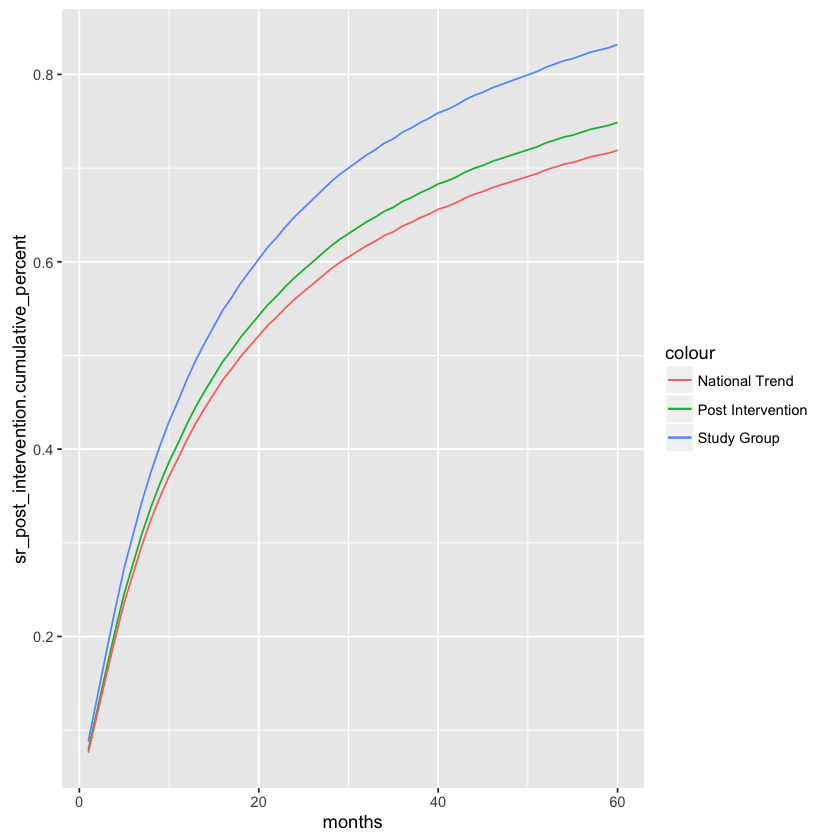

In [21]:
survival_rates <- read.csv("./clean_data/mschpprts05f02.csv", stringsAsFactors = F) %>% 
  filter(X != "",
         X != "National") %>% 
  mutate(In.state = as.numeric(X.1),
         cumulative_percent = In.state / 100,
         cumulative_prob_did_not = 1 - cumulative_percent,
         prob_recidivate = 1 - cumulative_prob_did_not / lag(cumulative_prob_did_not)) %>% filter(In.state != 0)

# Here are imputed survival rates. Basically, the data that Julie sent suggest that the national trends for recidivism are very similar to the Utah trends (or at least they were between 2012 and 2015).
# The data also show that our study group had a recidivsm rate that was 74.3% after 36 months, whereas all prisoners had a rate of 64.2% (again, close to natural). The difference between the control group and national trends is (74.3 - 64.2) / 64.2, OR:
COD_group_increase = 0.157

sr_study_group <- read.csv("./clean_data/mschpprts05f02.csv", 
                                 stringsAsFactors = F) %>% 
  filter(X != "",
         X != "National") %>% 
  mutate(In.state = as.numeric(X.1),
         In.state = In.state + (In.state * COD_group_increase)) %>% 
  mutate(cumulative_percent = In.state / 100,
         cumulative_prob_did_not = 1 - cumulative_percent,
         prob_recidivate = 1 - cumulative_prob_did_not / lag(cumulative_prob_did_not)) %>% filter(In.state != 0)


# Let's see what will happen post JRI
# Note that I am using a value from the assumptions above ^
COD_group_increase = 0.157

sr_post_intervention <- read.csv("./clean_data/mschpprts05f02.csv", 
                           stringsAsFactors = F) %>% 
  filter(X != "",
         X != "National") %>% 
  mutate(In.state_pre = as.numeric(X.1),
         In.state_pre = In.state_pre + (In.state_pre * COD_group_increase),
         In.state = In.state_pre - (In.state_pre * recid_reduction_JRI)) %>% 
  mutate(cumulative_percent = In.state / 100,
         cumulative_prob_did_not = 1 - cumulative_percent,
         prob_recidivate = 1 - cumulative_prob_did_not / lag(cumulative_prob_did_not)) %>% filter(In.state != 0)

sr_post_intervention$cum_per_of_reoffenders <- sr_post_intervention$In.state / sr_post_intervention$In.state[60]




# Put them together to plot

all_together <- data.frame(sr_post_intervention$cumulative_percent, sr_study_group$cumulative_percent, survival_rates$cumulative_percent)

all_together$months <- c(1:60)


ggplot(all_together, aes(months)) + 
  geom_line(aes(y = sr_post_intervention.cumulative_percent, colour = "Post Intervention")) + 
  geom_line(aes(y = sr_study_group.cumulative_percent, colour = "Study Group")) +
  geom_line(aes(y = survival_rates.cumulative_percent, colour = "National Trend"))  

